In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import statsmodels.api as sm
from sklearn.metrics import *
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import team_method

instance = team_method.character_stat()
instance.set_all( 100, 150)
instance.print1()

HP :  100
MP :  150


# Function

In [51]:
# modify dtype 
def str_to_num(df, train=True):
    '''
    ppl_id : del string and change dtype to num
    activity id : del number and str(act)
    type : del string and change dtype to num
    inplace : True
    
    parameta
    --------
    df : DataFrame 
    train : bool
        train :True, test : False
    '''
    col_list = list(df.columns)
    col_list.remove('date_x')
    col_list.remove('date_y')
    if train:
        col_list.remove('outcome')
        
    for col in col_list[:col_list.index('char_9_y')+1]:
        if col == 'activity_id':
            df[col] = df[col].apply(lambda x: x.split('_')[0])
            df.replace('act', '', regex=True, inplace = True)
        elif col == 'people_id':
            df[col] = df[col].apply(lambda x: x.split('_')[1])
        else :
            df[col][df[col].isnull()==False] = df[col][df[col].isnull()==False].apply(lambda x: x.split(' ')[1])
        df[col][df[col].isnull()==False] = pd.to_numeric(df[col][df[col].isnull()==False]).astype(int)
        
    return df

In [52]:
# add past_says and week
def date_modify(df):
    '''
    add week_x, week_y, and Past_days
    inplace : True
    
    parameta
    --------
    df : DataFrame 
    '''
    df.insert(loc=list(df).index('date_x')+1 ,column='week_x', value=df['date_x'].dt.weekday)
    df.insert(loc=list(df).index('date_y')+1 ,column='week_y', value=df['date_y'].dt.weekday)
    df.insert(loc=list(df).index('week_x')+1 ,column='Past_days', value=(df.date_x - df.date_y).astype('timedelta64[D]'))
    return df

In [53]:
# add bool_sum
def add_bool_sum(df):
    '''
    add colum 'bool_sum' : sum of char_10_y ~ char_37
    inplace : False
    
    parameta
    --------
    df : DataFrame 
    '''
    temp = df.copy()
    temp['bool_sum'] = temp.iloc[:,list(temp).index('char_10_y'):list(temp).index('char_37')].sum(axis=1)
    return temp

In [54]:
def num_to_cat(df, columns, encode=True):
    '''
    change dtype num to str and changed columns encoding(one-hot-encoding)
    
    parameta
    --------
    df : DataFrame 
    columns : list
        
    encode : bool
        True : one-hot-encoding
    '''
    temp = df.copy()
    temp[columns] = pd.DataFrame(temp[columns], dtype='str')
    pd.get_dummies(temp[columns], dummy_na=True)
    return temp

In [7]:
# dff = num_to_cat(df_merge, 'activity_category')

In [8]:
# def train_test_scores(model, cols, df=df_merge, count=10):
#     dfX = df.drop(['outcome'], axis=1)
#     dfy = df.outcome
#     scores = np.zeros(count)
#     for i in range(count):
#         X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=0.3, random_state=i)
#         model.fit(X_train[cols], y_train)
#         y_pred = model.predict(X_test[cols])
#         print(classification_report(y_test, y_pred))
# #         scores[i] = score(y_test, y_pred)
#     return scores

# data load & 전처리

### train data

In [9]:
df_train = pd.read_csv('./data/act_train.csv', parse_dates=['date'])
df_people = pd.read_csv('./data/people.csv', parse_dates=['date'])
df_merge = pd.merge(df_train, df_people, on='people_id')

In [10]:
str_to_num(df_merge, train=True)
date_modify(df_merge)
print('done!')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


done!


### test data

In [11]:
# df_test = pd.read_csv('./data/act_test.csv', parse_dates=['date'])
# df_merge_test = pd.merge(df_test, df_people, how='inner', on='people_id')

In [12]:
# str_to_num(df_merge_test, train=False)
# date_modify(df_merge_test)
# print('done!')

#### save data

In [13]:
# df_merge.to_csv("train_merge.csv")
# df_merge_test.to_csv("test_merge.csv")

In [14]:
# df_merge = pd.read_csv('./train_merge.csv', parse_dates=['date_x', 'date_y'])
# df_merge_test = pd.read_csv('./test_merge.csv', parse_dates=['date_x', 'date_y'])

# EDA

In [15]:
for d in ['date_x', 'date_y']:
    print('Start of ' + d + ': ' + str(df_merge[d].min().date()))
    print('  End of ' + d + ': ' + str(df_merge[d].max().date()))
    print('Range of ' + d + ': ' + str(df_merge[d].max() - df_merge[d].min()) + '\n')

Start of date_x: 2022-07-17
  End of date_x: 2023-08-31
Range of date_x: 410 days 00:00:00

Start of date_y: 2020-05-18
  End of date_y: 2023-08-31
Range of date_y: 1200 days 00:00:00



In [16]:
df_merge.describe()

,people_id,week_x,Past_days,outcome,week_y,char_38
count,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06,2.197291e+06
mean,2.023863e+05,3.231972e+00,2.593235e+02,4.439544e-01,3.142312e+00,4.998051e+01
std,1.159728e+05,1.558017e+00,2.748091e+02,4.968491e-01,1.528937e+00,3.608557e+01
min,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.032760e+05,2.000000e+00,1.700000e+01,0.000000e+00,2.000000e+00,0.000000e+00
50%,2.041670e+05,3.000000e+00,1.710000e+02,0.000000e+00,3.000000e+00,5.900000e+01
75%,2.997910e+05,4.000000e+00,4.230000e+02,1.000000e+00,4.000000e+00,8.200000e+01
max,3.982380e+05,6.000000e+00,1.197000e+03,1.000000e+00,6.000000e+00,1.000000e+02


In [17]:
df_merge[['date_x', 'date_y']].describe()

,date_x,date_y
count,2197291,2197291
unique,411,1196
top,2022-09-30 00:00:00,2022-03-02 00:00:00
freq,48174,55371
first,2022-07-17 00:00:00,2020-05-18 00:00:00
last,2023-08-31 00:00:00,2023-08-31 00:00:00


In [18]:
pd.DataFrame(df_merge.people_id, dtype='object').describe()

,people_id
count,2197291
unique,151295
top,294918
freq,55103


In [19]:
df_merge.people_id.unique()

array([   100, 100002, 100003, ...,   9999,  99992,  99994], dtype=int64)

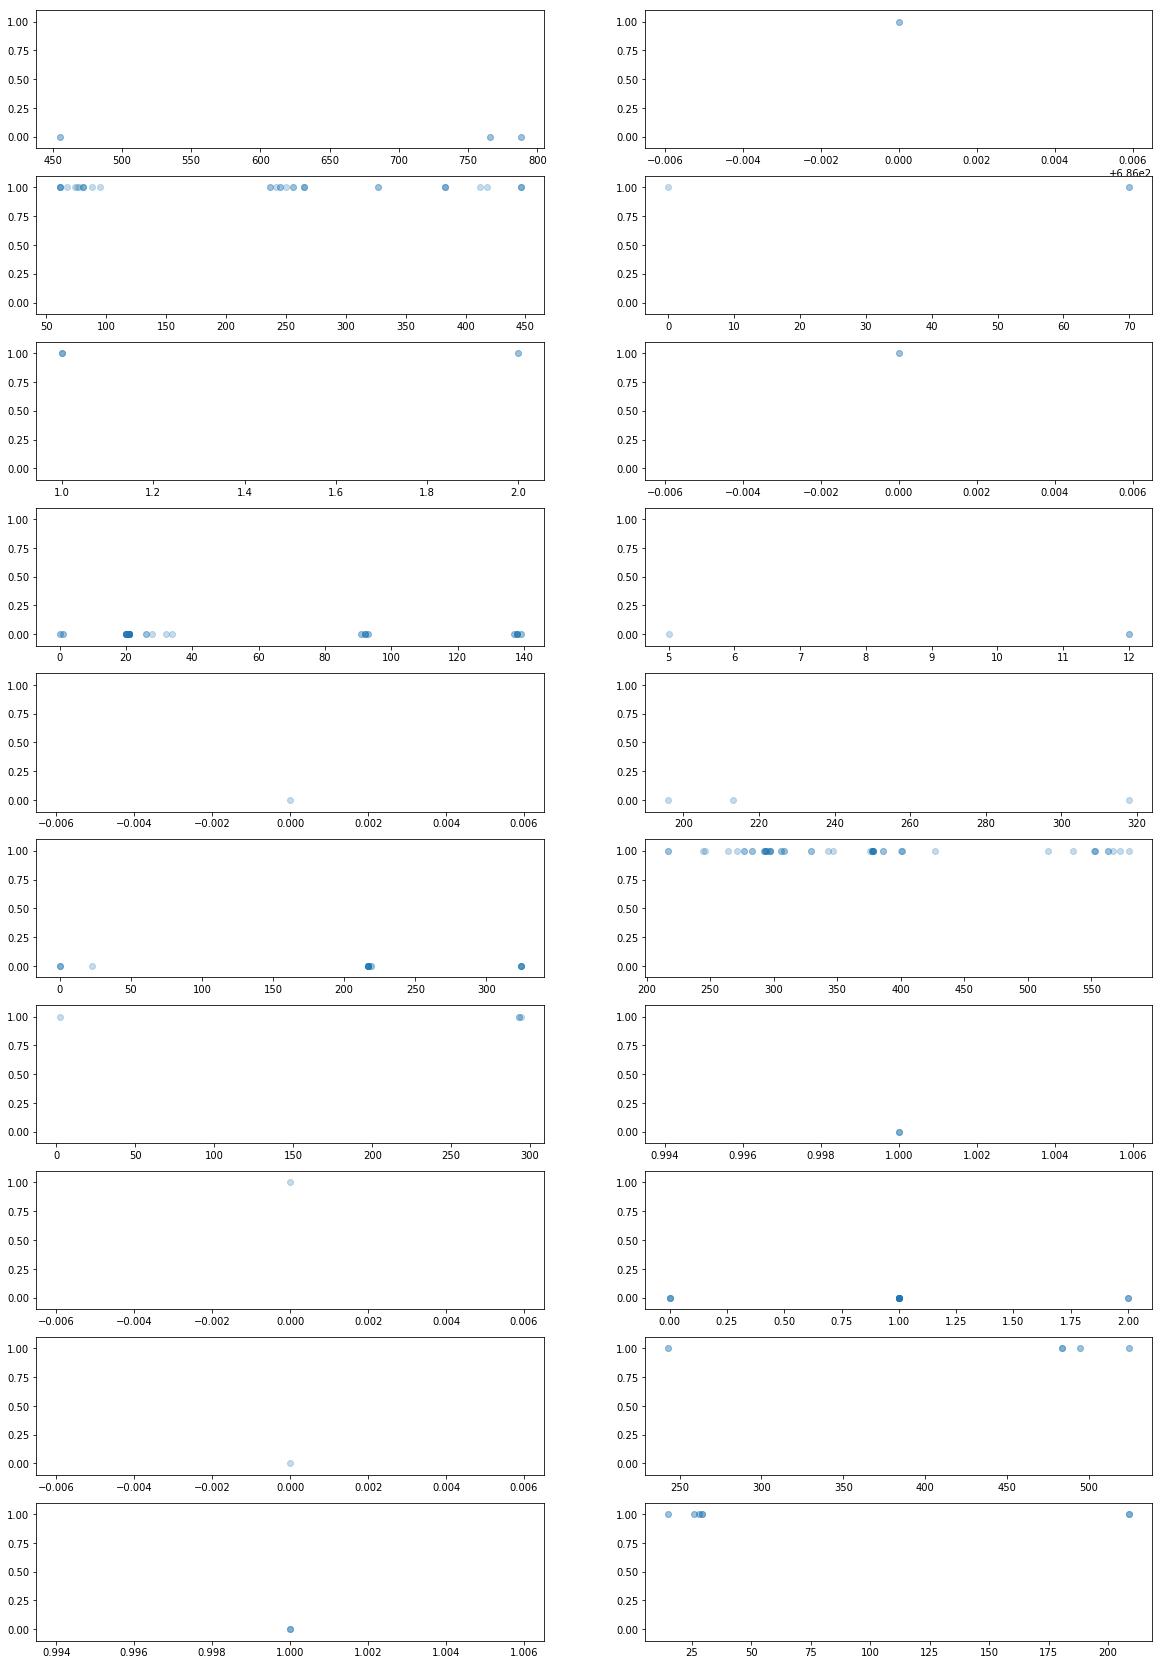

In [20]:
# ppl 별 구매 경향
plt.figure(figsize=(20,30))
for i, ppl in enumerate(df_merge.people_id.unique()[:20]):
    plt.subplot(10,2,i+1)    
    plt.scatter(df_merge[df_merge.people_id == ppl]['Past_days'], \
                df_merge[df_merge.people_id == ppl].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

In [21]:
df_merge.people_id.value_counts().head()

294918    55103
370270    53668
105739    45936
54699     23969
64887      7052
Name: people_id, dtype: int64

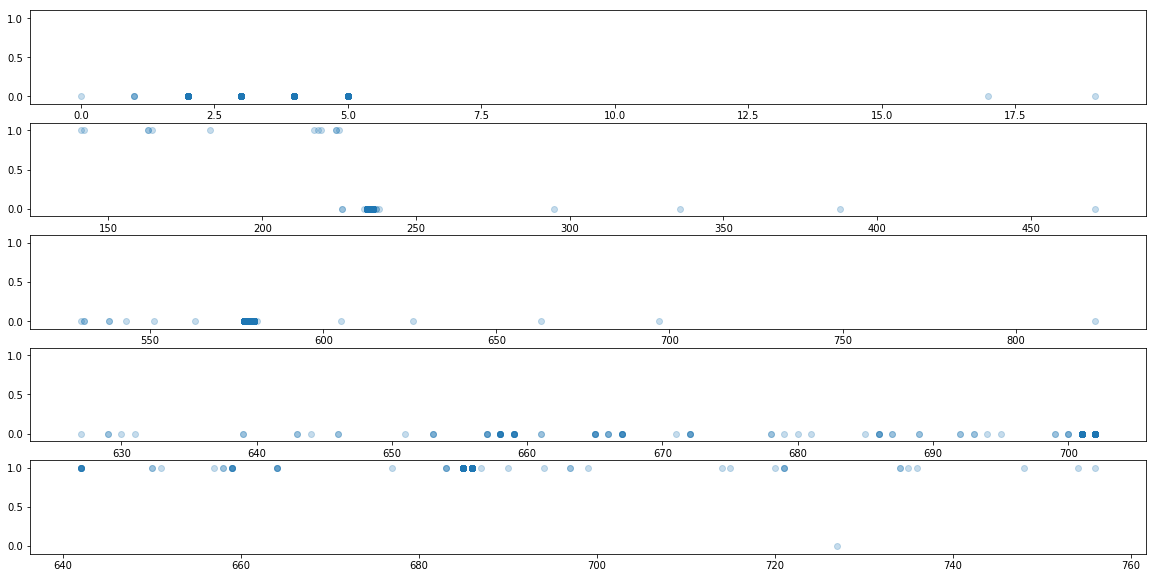

In [22]:
# ppl 별 구매 경향 top 5
plt.figure(figsize=(20,10))
for i, ppl in enumerate([294918, 370270, 105739, 54699, 64887]):
    plt.subplot(5,1,i+1)    
    plt.scatter(df_merge[df_merge.people_id == ppl]['Past_days'], \
                df_merge[df_merge.people_id == ppl].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

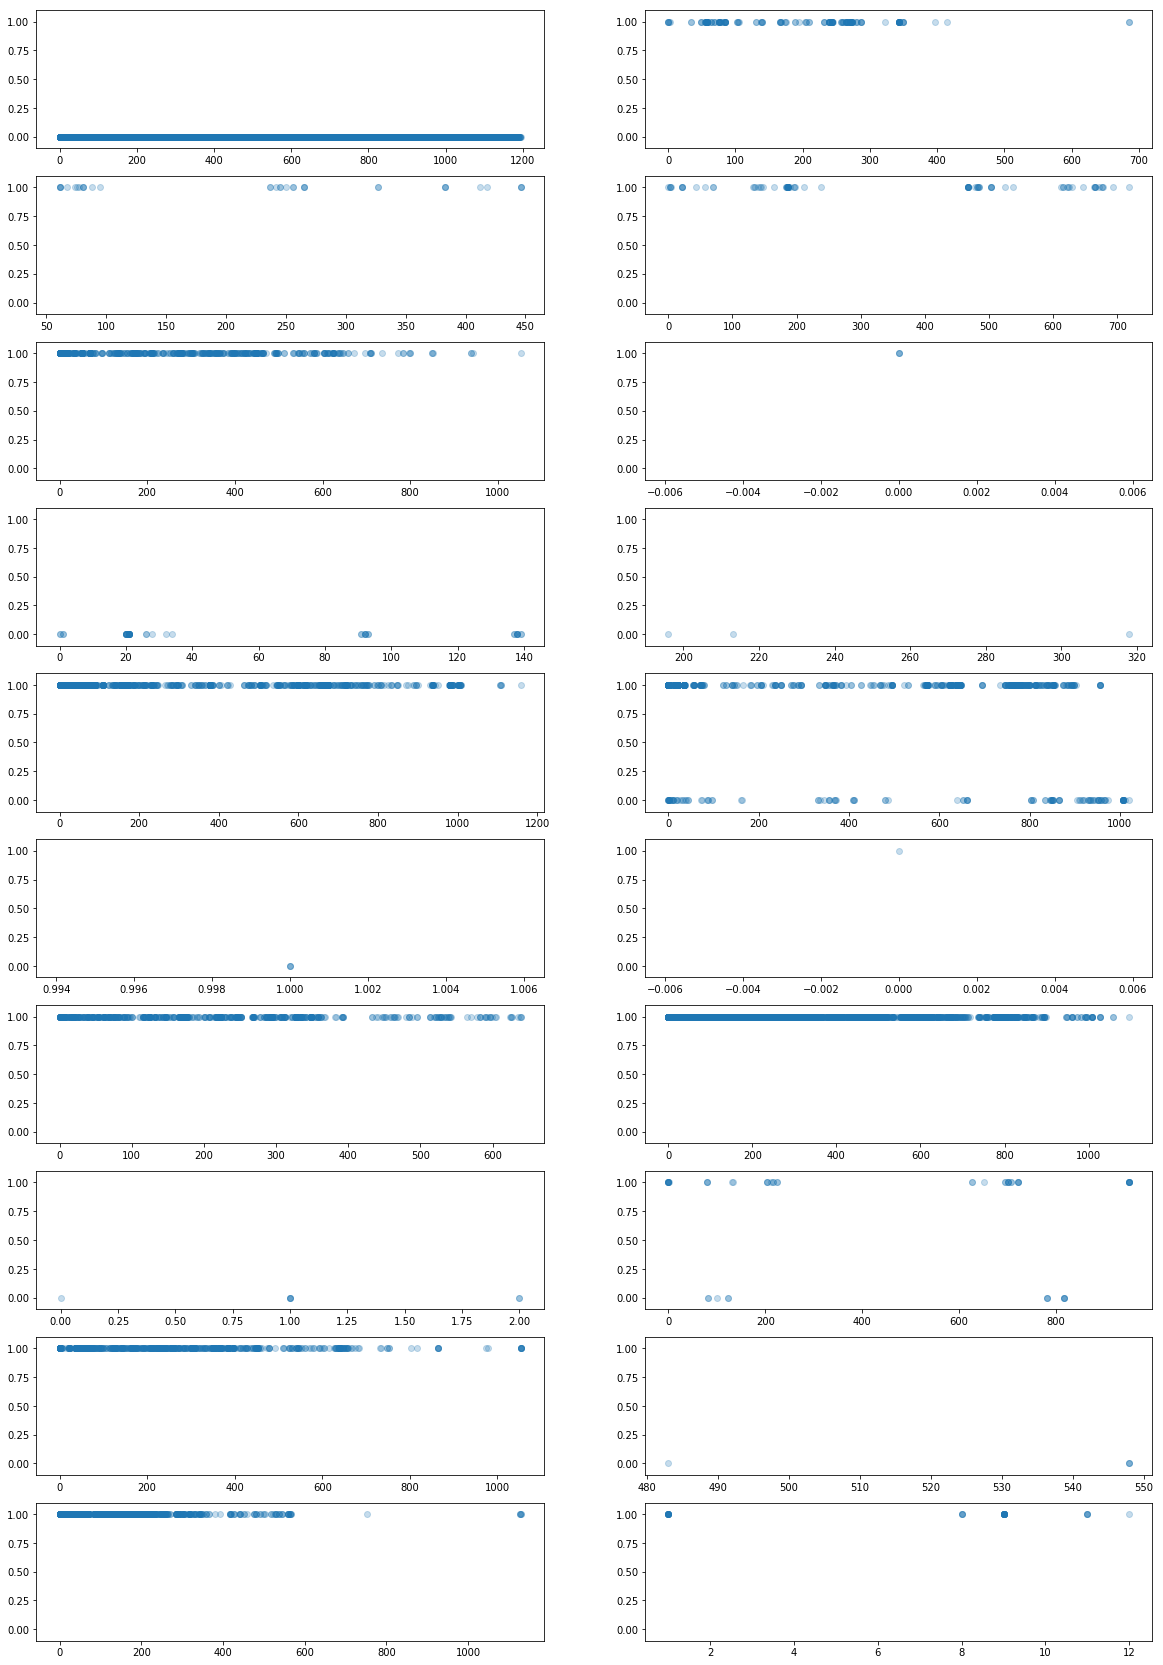

In [23]:
# group 별 구매 경향
plt.figure(figsize=(20,30))
for i, group in enumerate(df_merge.group_1.unique()[:20]):
    plt.subplot(10,2,i+1)    
    plt.scatter(df_merge[df_merge.group_1 == group]['Past_days'], \
                df_merge[df_merge.group_1 == group].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

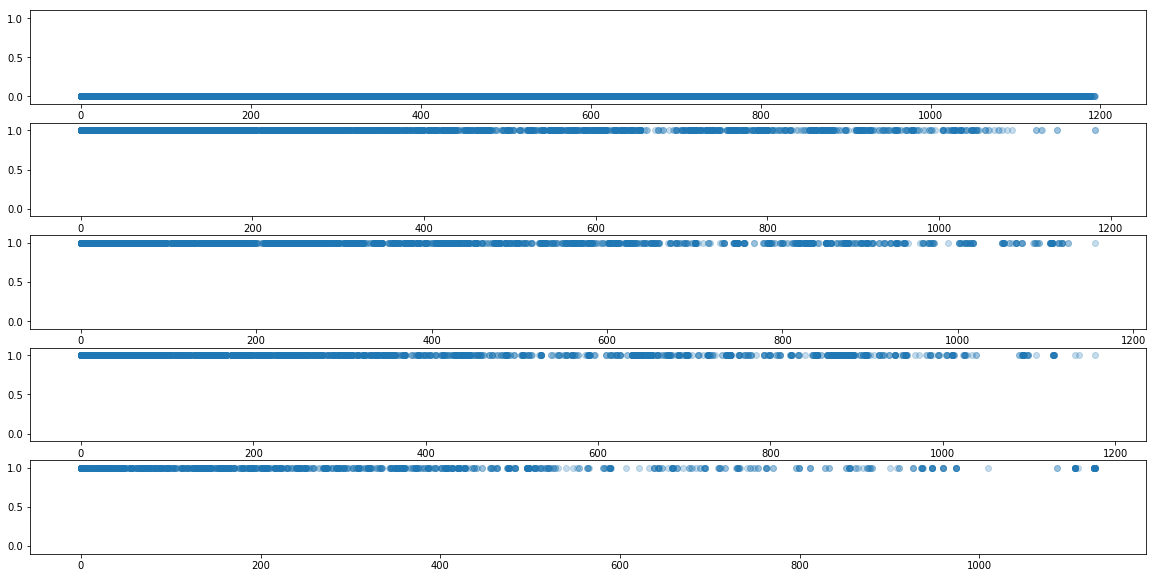

In [24]:
# group 별 구매 경향 top 5

plt.figure(figsize=(20,10))
for i, group in enumerate([17304, 667, 8386, 9280,450]):
    plt.subplot(5,1,i+1)    
    plt.scatter(df_merge[df_merge.group_1 == group]['Past_days'], \
                df_merge[df_merge.group_1 == group].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

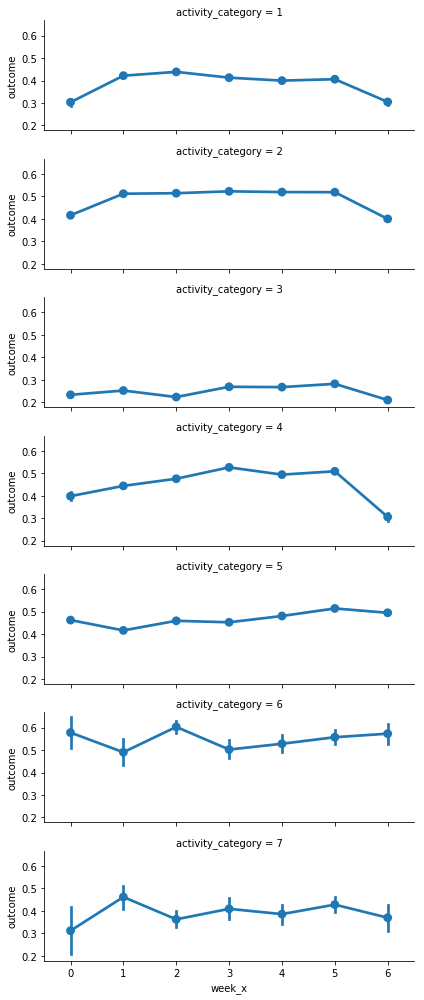

In [25]:
sns.factorplot(x="week_x", y="outcome", row="activity_category", data=df_merge,
               size=2, aspect=3, kind="point")
plt.show()

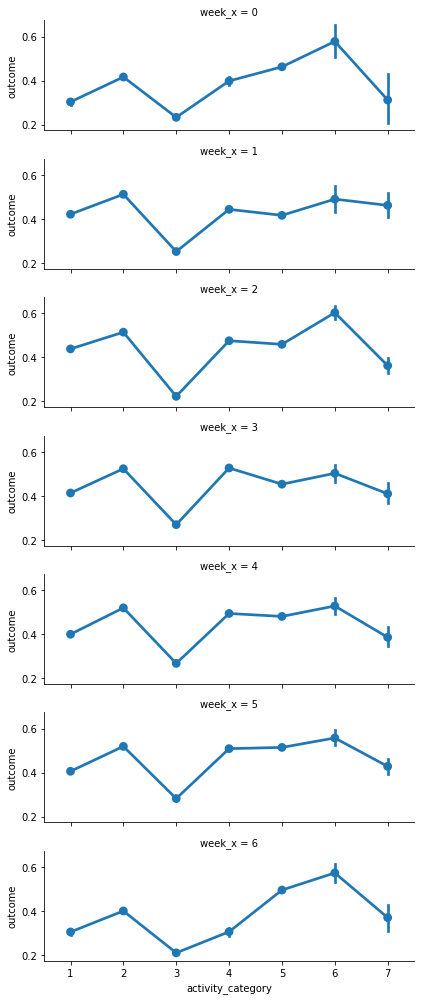

In [26]:
sns.factorplot(x="activity_category", y="outcome", row="week_x", data=df_merge,
               size=2, aspect=3, kind="point")
plt.show()

#### sample

In [27]:
df_sample = df_merge.sample(frac = 0.1, random_state=0).copy()
df_sample = add_bool_sum(df_sample)

In [28]:
df_sample2 = df_merge.sample(frac = 0.1, random_state=1).copy()
df_sample2 = add_bool_sum(df_sample2)

In [29]:
df_sample.groupby(['activity_id', 'activity_category']).count()

people_id  date_x  week_x  Past_days  char_1_x  \
activity_id activity_category                                                   
1           1                      15813   15813   15813      15813     15813   
2           2                      90498   90498   90498      90498         0   
            3                      42804   42804   42804      42804         0   
            4                      20891   20891   20891      20891         0   
            5                      48968   48968   48968      48968         0   
            6                        429     429     429        429         0   
            7                        326     326     326        326         0   

                               char_2_x  char_3_x  char_4_x  char_5_x  \
activity_id activity_category                                           
1           1                     15813     15813     15813     15813   
2           2                         0         0         0         0   
            3                         0         0         0         0   
            4                         0         0         0         0   
            5                         0         0         0         0   
            6                         0         0         0         0   
            7                         0         0         0         0   

                               char_6_x  char_7_x  char_8_x  char_9_x  \
activity_id activity_category                                           
1           1                     15813     15813     15813     15813   
2           2                         0         0         0         0   
            3                         0         0         0         0   
            4                         0         0         0         0   
            5                         0         0         0         0   
            6                         0         0         0         0   
            7                         0         0         0         0   

                               char_10_x  outcome  char_1_y  group_1  \
activity_id activity_category                                          
1           1                          0    15813     15813    15813   
2           2                      90498    90498     90498    90498   
            3                      42804    42804     42804    42804   
            4                      20891    20891     20891    20891   
            5                      48968    48968     48968    48968   
            6                        429      429       429      429   
            7                        326      326       326      326   

                               char_2_y  date_y  week_y  char_3_y  char_4_y  \
activity_id activity_category                                                 
1           1                     15813   15813   15813     15813     15813   
2           2                     90498   90498   90498     90498     90498   
            3                     42804   42804   42804     42804     42804   
            4                     20891   20891   20891     20891     20891   
            5                     48968   48968   48968     48968     48968   
            6                       429     429     429       429       429   
            7                       326     326     326       326       326   

                               char_5_y  char_6_y  char_7_y  char_8_y  \
activity_id activity_category                                           
1           1                     15813     15813     15813     15813   
2           2                     90498     90498     90498     90498   
            3                     42804     42804     42804     42804   
            4                     20891     20891     20891     20891   
            5                     48968     48968     48968     48968   
            6                       429       429       429       429   
            7                       326 

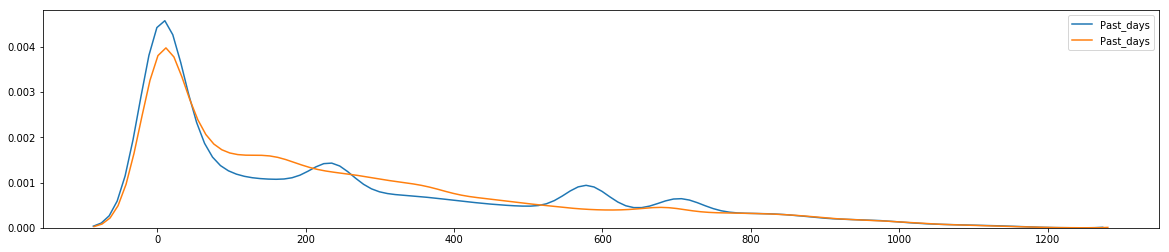

In [30]:
plt.figure(figsize=(20,4))
sns.kdeplot(df_sample[df_sample.outcome==0]['Past_days'])
sns.kdeplot(df_sample[df_sample.outcome==1]['Past_days'])
plt.show()

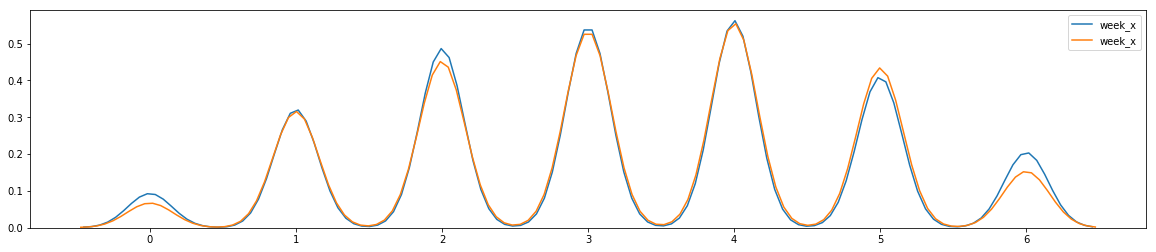

In [31]:
plt.figure(figsize=(20,4))
sns.kdeplot(df_sample[df_sample.outcome==0]['week_x'])
sns.kdeplot(df_sample[df_sample.outcome==1]['week_x'])
plt.show()

#### char_1_x ~ char_9_x

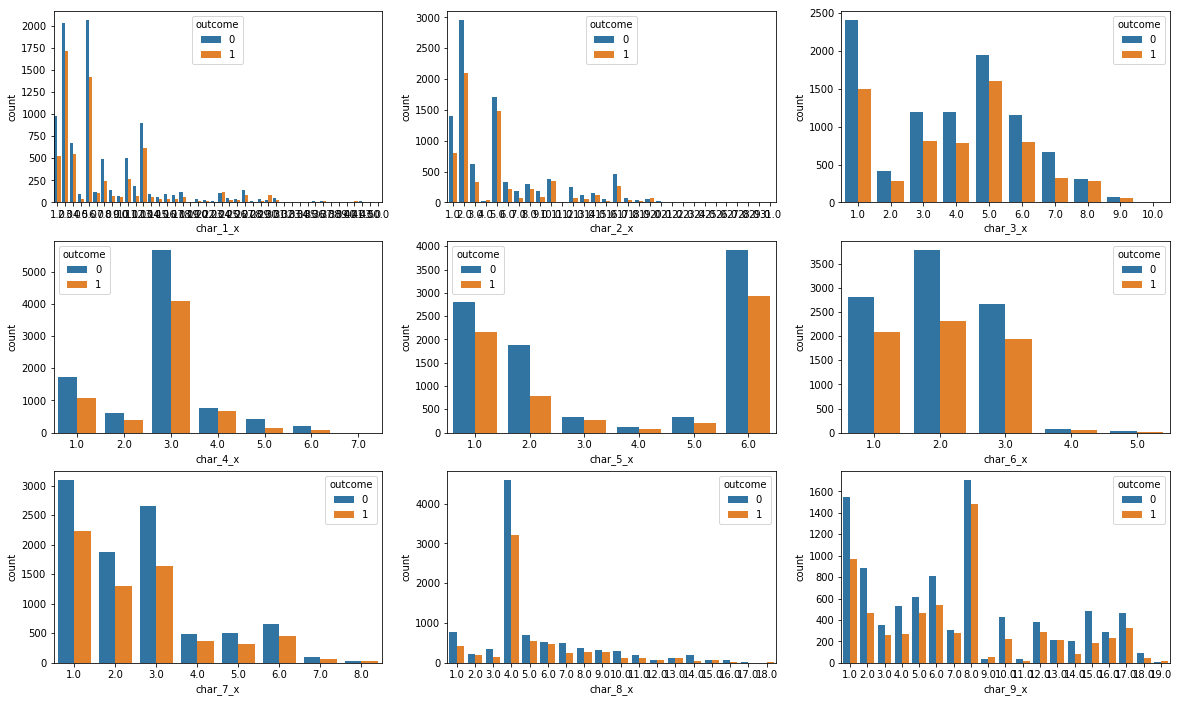

In [32]:
plt.figure(figsize=(20,12))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_1_x'):list(df_sample).index('char_9_x')+1]):
    plt.subplot(3,3,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

#### char_2_y ~ char_9_y

<function matplotlib.pyplot.show>

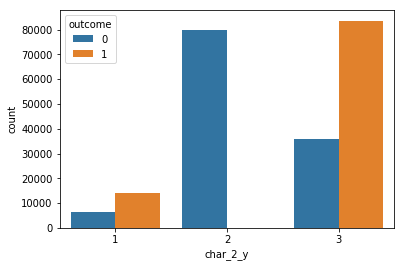

In [33]:
sns.countplot('char_2_y', hue='outcome', data=df_sample)
plt.show

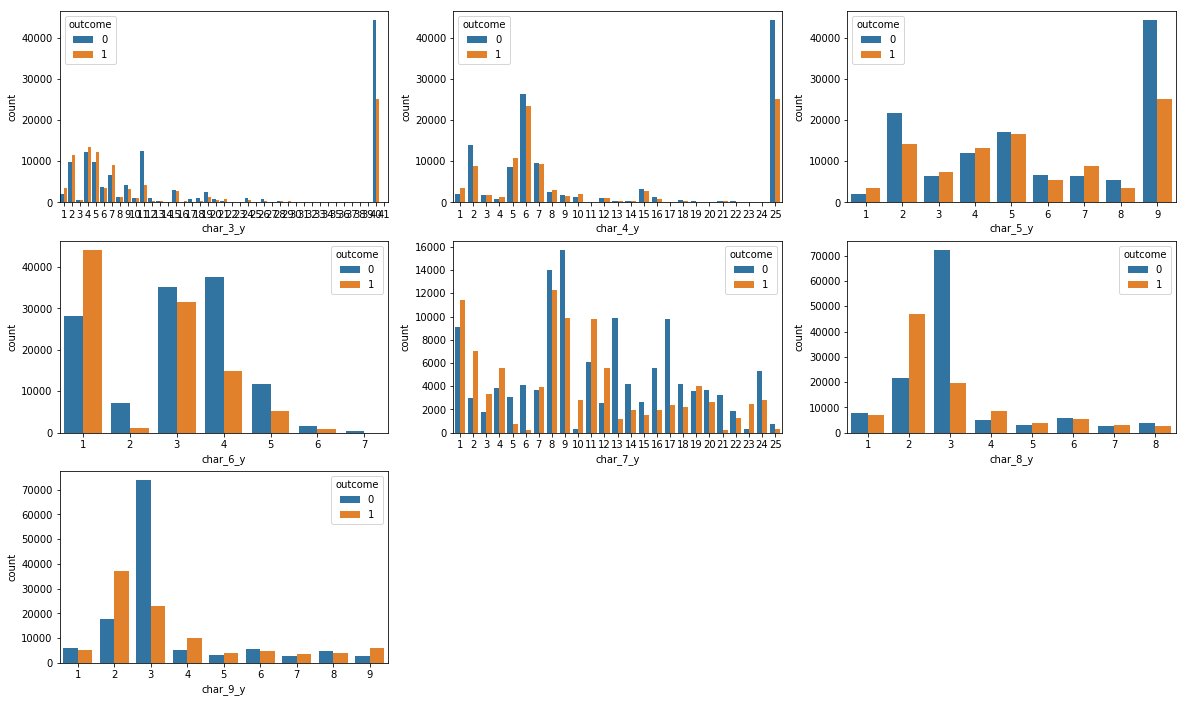

In [34]:
plt.figure(figsize=(20,12))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_3_y'):list(df_sample).index('char_9_y')+1]):
    plt.subplot(3,3,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

#### char_10_y ~ char_37

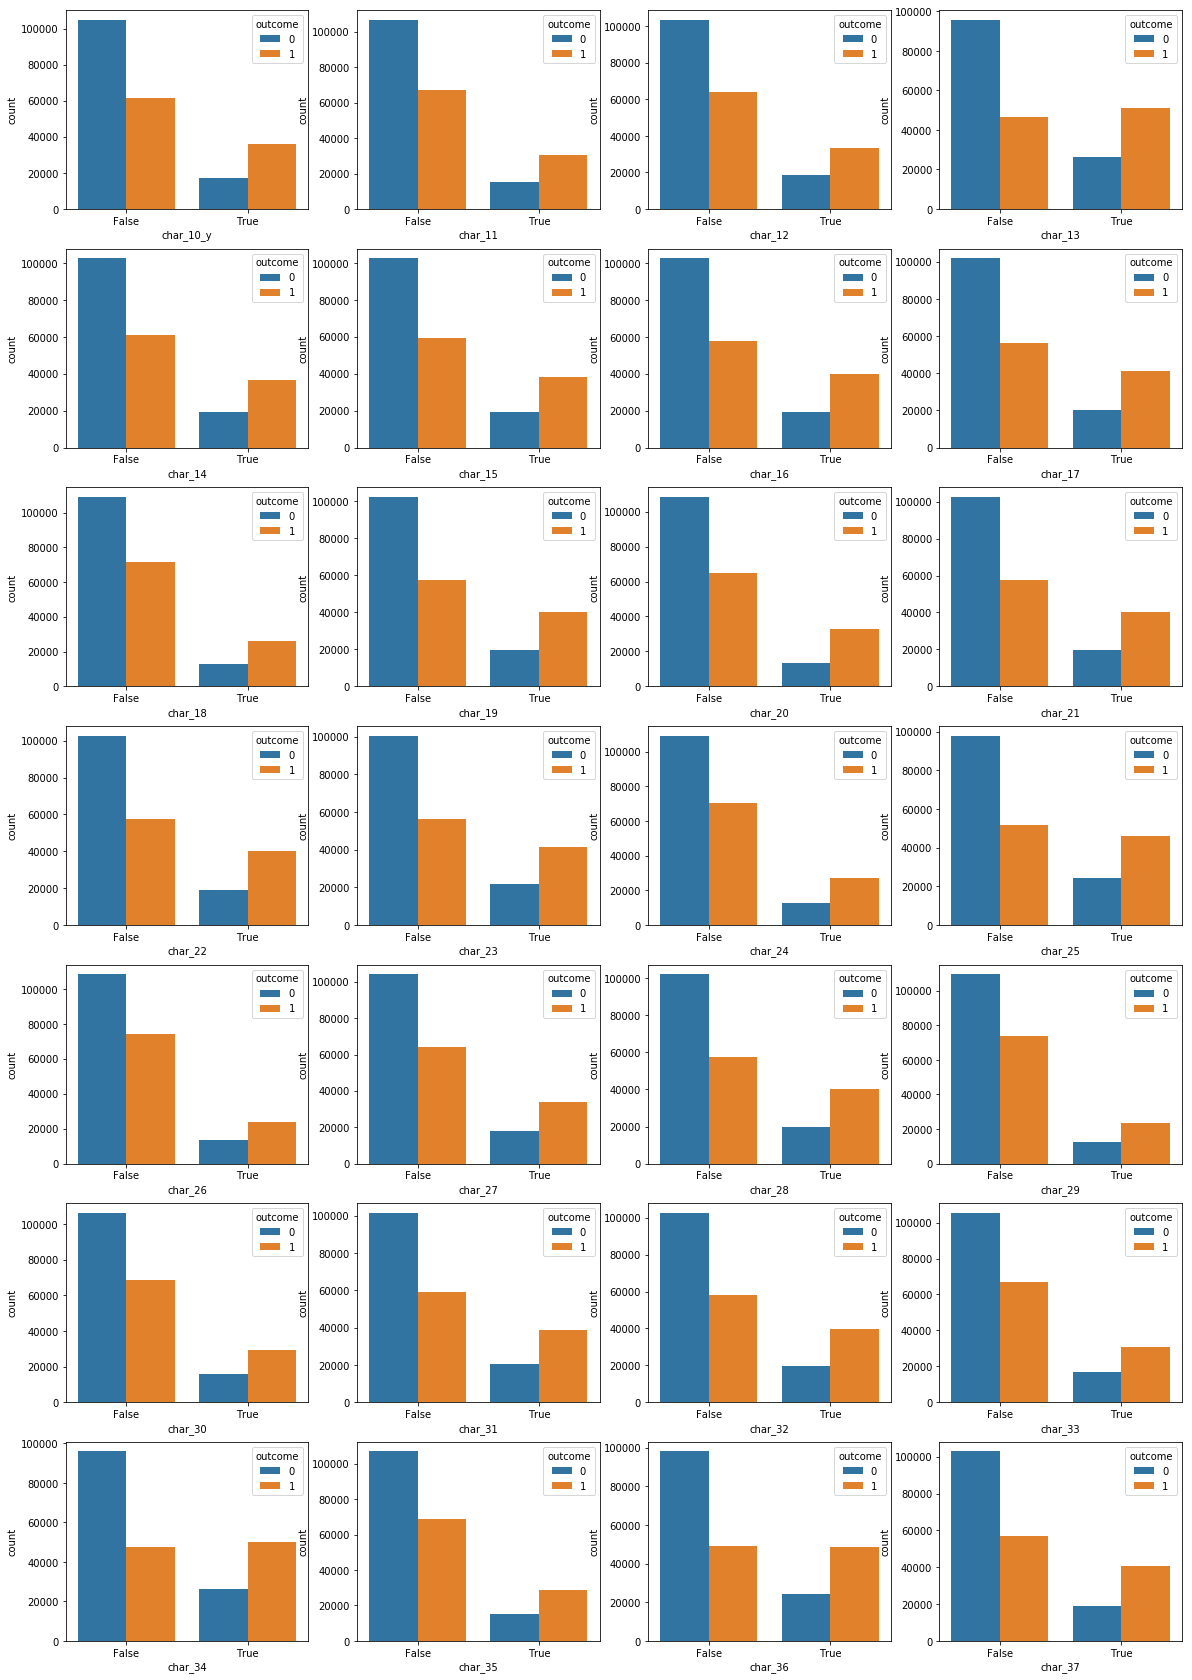

In [35]:
plt.figure(figsize=(20,30))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_10_y'):list(df_sample).index('char_37')+1]):
    plt.subplot(7,4,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

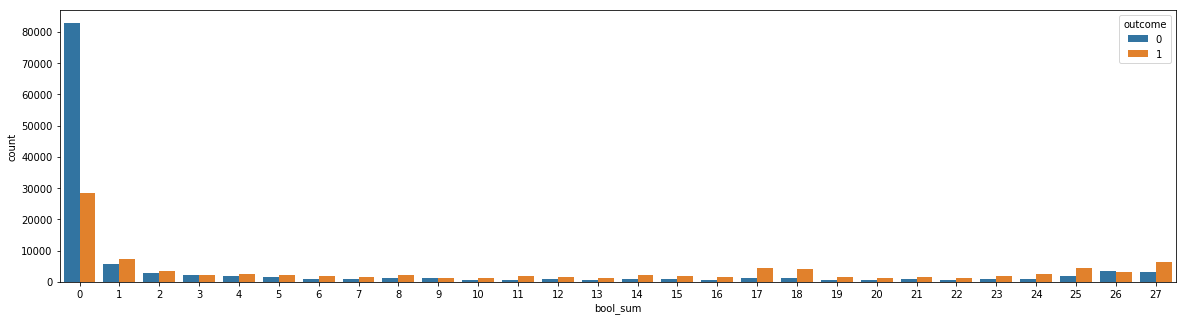

In [36]:
plt.figure(figsize=(20,5))
sns.countplot('bool_sum', hue='outcome', data=df_sample)
plt.show()

#### char_38

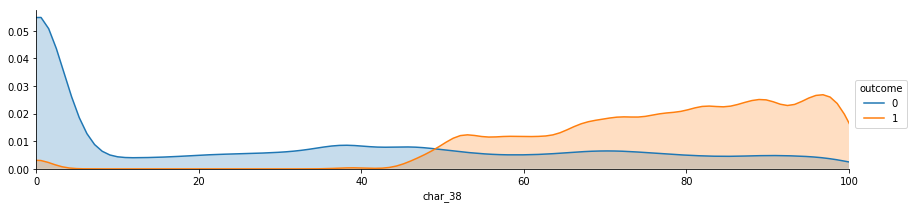

In [37]:
facet = sns.FacetGrid(df_sample, hue='outcome', aspect=4)
facet.map(sns.kdeplot, 'char_38', shade=True)
facet.set(xlim=(0, df_sample['char_38'].max()))
facet.add_legend()

plt.show()

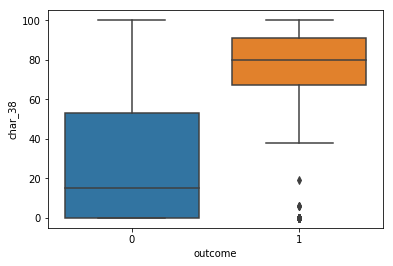

In [38]:
sns.boxplot(x="outcome", y="char_38", data=df_sample)
plt.show()

# feature selection

In [39]:
model1 = sm.OLS.from_formula("outcome ~ char_10_y + char_11 + char_12 + char_13 + char_14 + char_15 + char_16 + char_17 + char_18 + \
                            char_19 + char_20 + char_21 + char_22 + char_23 + char_24 + char_25 + char_26 + char_27 + char_28 + \
                            char_29 + char_30 + char_31 + char_32 + char_33 + char_34 + char_35 + char_36 + char_37", data=df_sample)
model2 = sm.OLS.from_formula("outcome ~ bool_sum", data=df_sample)
model3 = sm.OLS.from_formula("outcome ~ char_10_y + char_11 + char_12 + char_13 + char_14 + char_15 + char_16 + char_17 + char_18 + \
                            char_19 + char_20 + char_21 + char_22 + char_23 + char_24 + char_25 + char_26 + char_27 + char_28 + char_29 + \
                            char_30 + char_31 + char_32 + char_33 + char_34 + char_35 + char_36 + char_37 + bool_sum", data=df_sample)
result1 = model1.fit()
result2 = model2.fit()
result3 = model3.fit()

sm.stats.anova_lm(result1, result2, result3)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,219700.0,46857.157836,0.0,NaN,NaN,NaN
1,219727.0,48828.030772,-27.0,-1970.872935,342.233581,NaN
2,219700.0,46860.001295,27.0,1968.029477,341.739827,0.0


In [40]:
sm.stats.anova_lm(result1)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
char_10_y,1.0,3897.277449,3897.277449,18273.234976,0.000000e+00
char_11,1.0,351.633842,351.633842,1648.711930,0.000000e+00
char_12,1.0,127.622569,127.622569,598.386238,5.649735e-132
char_13,1.0,1416.133030,1416.133030,6639.848449,0.000000e+00
char_14,1.0,64.990676,64.990676,304.722951,3.427460e-68
char_15,1.0,34.372966,34.372966,161.165146,6.487422e-37
char_16,1.0,38.722422,38.722422,181.558519,2.299325e-41
char_17,1.0,58.783017,58.783017,275.616993,7.388177e-62
char_18,1.0,4.212364,4.212364,19.750585,8.827773e-06
char_19,1.0,1.880477,1.880477,8.817028,2.984646e-03


In [41]:
sm.stats.anova_lm(result2)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
bool_sum,1.0,5423.448232,5423.448232,24405.612735,0.0
Residual,219727.0,48828.030772,0.222221,NaN,NaN


In [42]:
sm.stats.anova_lm(result3)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
char_10_y,1.0,3897.277449,3897.277449,18272.126158,0.000000e+00
char_11,1.0,351.633842,351.633842,1648.611886,0.000000e+00
char_12,1.0,127.622569,127.622569,598.349928,5.753133e-132
char_13,1.0,1416.133030,1416.133030,6639.445544,0.000000e+00
char_14,1.0,64.990676,64.990676,304.704461,3.459354e-68
char_15,1.0,34.372966,34.372966,161.155367,6.519394e-37
char_16,1.0,38.722422,38.722422,181.547502,2.312085e-41
char_17,1.0,58.783017,58.783017,275.600268,7.450364e-62
char_18,1.0,4.212364,4.212364,19.749387,8.833310e-06
char_19,1.0,1.880477,1.880477,8.816493,2.985521e-03


# modeling

#### train, test split

## 로지스틱 회귀분석

In [43]:
df_sample.keys()

Index(['people_id', 'activity_id', 'date_x', 'week_x', 'Past_days',
       'activity_category', 'char_1_x', 'char_2_x', 'char_3_x', 'char_4_x',
       'char_5_x', 'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_10_x',
       'outcome', 'char_1_y', 'group_1', 'char_2_y', 'date_y', 'week_y',
       'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y',
       'char_9_y', 'char_10_y', 'char_11', 'char_12', 'char_13', 'char_14',
       'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_20',
       'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26',
       'char_27', 'char_28', 'char_29', 'char_30', 'char_31', 'char_32',
       'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38',
       'bool_sum'],
      dtype='object')

In [44]:
logit_mod = sm.Logit.from_formula("outcome ~ Past_days + char_38 + bool_sum", data=df_sample)
logit_res = logit_mod.fit(disp=0)
print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               219729
Model:                          Logit   Df Residuals:                   219725
Method:                           MLE   Df Model:                            3
Date:                Tue, 14 Nov 2017   Pseudo R-squ.:                  0.4089
Time:                        21:07:24   Log-Likelihood:                -89217.
converged:                       True   LL-Null:                   -1.5094e+05
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.6450      0.018   -201.199      0.000      -3.681      -3.610
Past_days     -0.0001   2.17e-05     -6.093      0.000      -0.000   -8.97e-05
char_38        0.0625      0.000    232.381      0.0

## 나이브 베이즈

+ 베르누이 분포 나이브 베이즈 모형

In [45]:
df_sample.columns[-30:-2]

Index(['char_10_y', 'char_11', 'char_12', 'char_13', 'char_14', 'char_15',
       'char_16', 'char_17', 'char_18', 'char_19', 'char_20', 'char_21',
       'char_22', 'char_23', 'char_24', 'char_25', 'char_26', 'char_27',
       'char_28', 'char_29', 'char_30', 'char_31', 'char_32', 'char_33',
       'char_34', 'char_35', 'char_36', 'char_37'],
      dtype='object')

In [46]:
X = df_sample[df_sample.columns[-30:-2]]; y = df_sample.outcome

In [47]:
from sklearn.naive_bayes import BernoulliNB
clf_bern = BernoulliNB().fit(X, y)

In [48]:
print(classification_report(df_sample2.outcome, clf_bern.predict(df_sample2[df_sample2.columns[-30:-2]])))

             precision    recall  f1-score   support

          0       0.67      0.80      0.73    121787
          1       0.67      0.50      0.57     97942

avg / total       0.67      0.67      0.66    219729



+ 가우시안 정규 분포 나이브 베이즈 모형

In [49]:
a = list(df_merge)
a.remove('date_x')
a.remove('date_y')
print(a)

['people_id', 'activity_id', 'week_x', 'Past_days', 'activity_category', 'char_1_x', 'char_2_x', 'char_3_x', 'char_4_x', 'char_5_x', 'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_10_x', 'outcome', 'char_1_y', 'group_1', 'char_2_y', 'week_y', 'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y', 'char_10_y', 'char_11', 'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_20', 'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29', 'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38']


In [50]:
from sklearn.naive_bayes import GaussianNB
X = df_sample[a]
y = df_sample.outcome
clf_norm = GaussianNB().fit(X, y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
print(classification_report(df_sample2.outcome, clf_norm.predict(df_sample2[a])))

## 의사 결정 나무

In [ ]:
tree = DecisionTreeClassifier(criterion='entropy').fit(df_sample[a], df_sample.outcome)
print(classification_report(df_sample2.outcome, tree.predict(df_sample2[a])))

In [ ]:
tree2 = DecisionTreeClassifier(criterion='entropy').fit(df_sample[a2], df_sample.outcome)
print(classification_report(df_sample2.outcome, tree2.predict(df_sample2[a2])))

## 랜덤 포레스트

+ RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=10).fit(df_sample[a], df_sample.outcome)
print(classification_report(df_sample2.outcome, rfc.predict(df_sample2[a])))

In [ ]:
rfc = RandomForestClassifier(n_estimators=20).fit(df_sample[a], df_sample.outcome)
print(classification_report(df_sample2.outcome, rfc.predict(df_sample2[a])))

In [ ]:
rfc = RandomForestClassifier(n_estimators=50).fit(df_sample[a], df_sample.outcome)
print(classification_report(df_sample2.outcome, rfc.predict(df_sample2[a])))

In [ ]:
rfc = RandomForestClassifier(n_estimators=30).fit(df_sample[a], df_sample.outcome)
print(classification_report(df_sample2.outcome, rfc.predict(df_sample2[a])))

In [ ]:
rfc = RandomForestClassifier(n_estimators=30).fit(df_sample[a2], df_sample.outcome)
print(classification_report(df_sample2.outcome, rfc.predict(df_sample2[a2])))

+ ExtraTreesClassifier

In [ ]:
efc = ExtraTreesClassifier(n_estimators=30).fit(df_sample[a], df_sample.outcome)
print(classification_report(df_sample2.outcome, efc.predict(df_sample2[a])))

In [ ]:
efc = ExtraTreesClassifier(n_estimators=30).fit(df_sample[a2], df_sample.outcome)
print(classification_report(df_sample2.outcome, efc.predict(df_sample2[a2])))

# xgboost

In [ ]:
import xgboost

xgb = xgboost.XGBClassifier(n_estimators=30).fit(df_sample[a], df_sample.outcome)
print(classification_report(df_sample2.outcome, xgb.predict(df_sample2[a])))

In [ ]:
xgb = xgboost.XGBClassifier(n_estimators=30).fit(df_sample[a2], df_sample.outcome)
print(classification_report(df_sample2.outcome, xgb.predict(df_sample2[a2])))

In [ ]:
xgb = xgboost.XGBClassifier(n_estimators=30)